<div>
<img src="https://notebooks.dtcglaciers.org/_images/ESA_logo.svg" width="160" align='right'/>
</div>

# Creating DTC-Glaciers User-DT-Enhanced Data cubes (L3)

If required, install the DTCG API using the following command:

```
!pip install 'dtcg[jupyter] @ git+https://github.com/DTC-Glaciers/dtcg'
```

Run this command in a notebook cell.

In [1]:
# Imports
import dtcg.integration.oggm_bindings as oggm_bindings
import dtcg.integration.calibration as calibration

from oggm.core import massbalance

import matplotlib.pyplot as plt
import numpy as np

A **central part** wich makes DTC-Glaciers a **Digital Twin** is that **users** not only can download precomputed data, but to make it easy to **interact with the system** by providing your **own data** and use it for the creation of your own 'model-data cubes' (**L3**). And finally **validate** your newly created data cube and compare them to precomputed data cubes provided by DTC-Glaciers, also by integrating your **own data**

## Preparing the scene

In this example we concentrate on Iceland, where we got example in-situ mass balance data from he **National Power Company of Iceland [Landsvirkjun](https://www.landsvirkjun.com/)**, a key stakeholder of DTC-Glaciers.

We use **Brúarjökull** again:

In [2]:
import logging
import xarray as xr
import salem

from oggm import utils, cfg

# Module logger
log = logging.getLogger(__name__)

if 'iceland_smb' not in cfg.BASENAMES:
    cfg.BASENAMES['iceland_smb'] = ('iceland_smb.nc', 'SMB for Iceland (DTCG)')

file_url = 'https://cluster.klima.uni-bremen.de/~dtcg/test_files/case_study_regions/iceland/vatnajokull_SMB_maps_1996-2024_a&s_v1.nc'


@utils.entity_task(log, writes=['iceland_smb'])
def add_iceland_smb(gdir):
    """Adds SMB to the glacier directory and reprojects the data onto the L1 grid."""

    # Template dataset
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as dsg:
        dsg = dsg[['x', 'y']].copy()

    # Transform SMB to glacier map
    with salem.open_xr_dataset(utils.file_downloader(file_url)) as ds_smb:
        dsg = dsg.salem.transform(ds_smb[['ba', 'b']], interp='linear')

    # Write it up
    dsg.to_netcdf(gdir.get_filepath('iceland_smb'))

In [3]:
rgi_id_ice = "RGI60-06.00377"  # Brúarjökull
dtcg_oggm_ice = oggm_bindings.BindingsOggmModel(rgi_id=rgi_id_ice)

def get_l2_data_tree(rgi_id):
    l2_datacube_url = "https://cluster.klima.uni-bremen.de/~dtcg/datacubes_case_study_regions/L1_and_L2/"
    return xr.open_datatree(
            f"{l2_datacube_url}{rgi_id}.zarr",
            chunks={},
            engine="zarr",
            consolidated=True,
            decode_cf=True,
        )

data_tree_ice = get_l2_data_tree(rgi_id_ice)

In [4]:
# add user data
from oggm import workflow
workflow.execute_entity_task(add_iceland_smb, dtcg_oggm_ice.gdir);

# open user data
with xr.open_dataset(dtcg_oggm_ice.gdir.get_filepath('iceland_smb')) as ds_user:
    ds_user = ds_user
ds_user

<xarray.Dataset> Size: 112MB
Dimensions:  (time_a: 29, y: 370, x: 436, time: 58)
Coordinates:
  * time_a   (time_a) datetime64[ns] 232B 1996-10-01 1997-10-01 ... 2024-10-01
  * y        (y) float32 1kB 7.201e+06 7.201e+06 ... 7.127e+06 7.127e+06
  * x        (x) float32 2kB 3.94e+05 3.942e+05 3.944e+05 ... 4.808e+05 4.81e+05
  * time     (time) datetime64[ns] 464B 1996-05-01 1996-10-01 ... 2024-10-01
Data variables:
    ba       (time_a, y, x) float64 37MB ...
    b        (time, y, x) float64 75MB ...
Attributes:
    pyproj_srs:  +proj=utm +zone=28 +datum=WGS84 +units=m +no_defs

Let's have a first look on the gridded data and the mean annual mass balance:

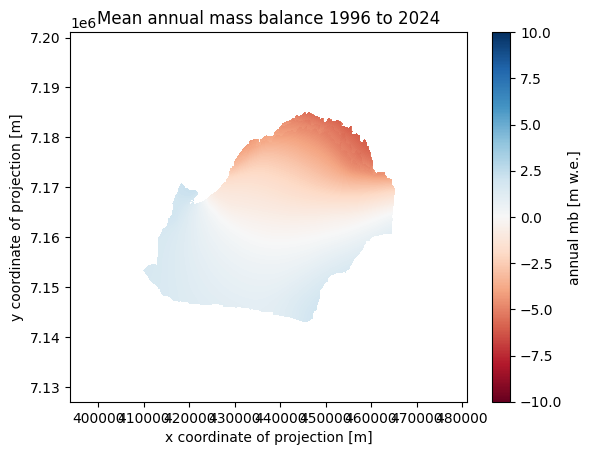

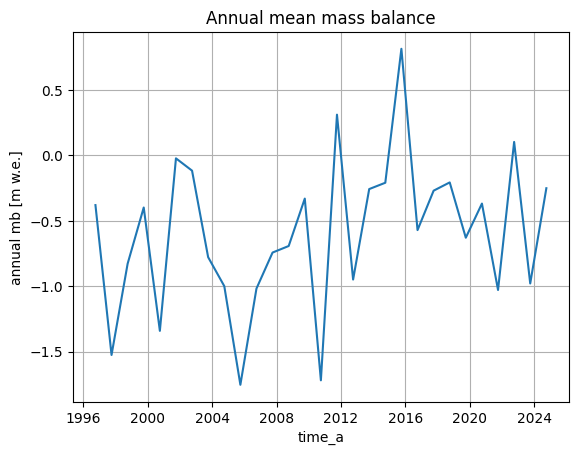

In [5]:
annual_smb = ds_user['ba'].where(dtcg_oggm_ice.l1_datacube.glacier_mask)
avg_smb = annual_smb.mean(dim='time_a', keep_attrs=True)
avg_smb.plot(cmap='RdBu', vmin=-10, vmax=10)
plt.title('Mean annual mass balance 1996 to 2024')
plt.show()

annual_smb.mean(dim=('y','x')).plot();
plt.grid('on')
plt.title('Annual mean mass balance')
plt.show()

## Create L3 data cubes

The main idea of **DTC-Glaciers** is to **make it easy** for potential users **to interact** with the system and to generate custom model output, instead of relying only on traditional preprocessed static model output. For this we show case here a first use case where the user can provide it's own observations and generate **L3** data cubes.

Let's prepare the user data as cumulated mass balance between 2010 and 2020:

In [6]:
def get_date_string(date):
    return np.datetime_as_string(date, unit="D").item()

start_date = annual_smb.time_a[14].values  # 2010
end_date = annual_smb.time_a[24].values  # 2020

# the period of the reference mass balance, e.g. '2010-01-01_2020-01-01'
ref_mb_period = (f"{get_date_string(start_date)}_"
                 f"{get_date_string(end_date)}")

# the actual observation value calculated as the cumulative mass balance over the period of interest
annual_cumsum_smb = annual_smb.mean(dim=('y','x')).cumsum()
ref_mb = (annual_cumsum_smb.sel(time_a=end_date).values -
          annual_cumsum_smb.sel(time_a=start_date).values
         ) * 1000  # convert to mm w.e., which is equal to kg m-2

# the unit of the provided observation
ref_mb_unit = 'kg m-2'

# an associated uncertainty, in this example we just set a typical order of magnitude
ref_mb_err = 1000 

# this description is add to the attributes of the resulting datacubes for reference
calibration_strategy = ("OGGM model DailyTIModel calibrated with user data "
                        f"from Landsvirkjun over the period {ref_mb_period}.")

# this is the name which will be used when adding the datacube to a datatree
l3_datacube_name = (f"L3_Daily_Landsvirkjun_"
                    f"{get_date_string(start_date).split('-')[0]}_"
                    f"{get_date_string(end_date).split('-')[0]}")

Currently DTC-Glaciers only supports the calibration of the mass balance over a complete refernece period. However, in OGGM it is possible to calibrate wih a non-complete set of mass balance observations, only taking specific years into account. This functionality could potantially be included to DTC-Glaciers in the future.

Let's provide the user data to the calibrator and create **L3** data cubes. For this we use `calibrator.calibrate_mb_and_create_data cubes`, which takes as input the mass balance model to calibrate and the referene mass balance values:

In [7]:
calibrator = calibration.CalibratorCryotempo(l1_datacube=data_tree_ice['L1'].ds,
                                             gdir=dtcg_oggm_ice.gdir)

l3_datacubes = calibrator.calibrate_mb_and_create_datacubes(
    mb_model_class=massbalance.DailyTIModel,
    ref_mb=ref_mb,
    ref_mb_err=ref_mb_err,
    ref_mb_unit=ref_mb_unit,
    ref_mb_period=ref_mb_period,
    calibration_strategy=calibration_strategy,
    datacubes_requested=['monthly', 'annual_hydro', 'daily_smb'],
    show_log=True,  # to see what is happening
    # we set here a small ensemble number for MCS for demonstration to reduce computing time,
    # the precomputed datacubes use 2**4~100 ensemble members
    mcs_sampling_settings={'nr_samples': 2**1},
)

DailyTIModel_2010-10-01_2020-10-01:
  Starting Monte Carlo Simulation for 12 ensemble members.
  Finished Monte Carlo Simulation: 12 ensemble members for output aggregation available.
  Start generating datacubes
    Start generation of monthly datacube
    Finished generation of monthly datacube
    Start generation of annual_hydro datacube
    Finished generation of annual_hydro datacube
    Start generation of daily_smb datacube
    Finished generation of daily_smb datacube
  Finished generating datacubes



The resulting **L3** data cube can be added to an existing data_tree the same way as **L2** data cubes:

In [8]:
from dtcg.datacube.geozarr import GeoZarrHandler

datacube_handler = GeoZarrHandler(data_tree=data_tree_ice)

datacube_handler.add_layer(datacubes=l3_datacubes, 
                           datacube_name=l3_datacube_name)

list(datacube_handler.data_tree.keys())

['L1',
 'L2_Daily_Cryosat_2011_2020',
 'L2_Daily_Hugonnet_2000_2020',
 'L2_Daily_Hugonnet_2010_2020',
 'L2_SfcDaily_Cryosat_2011_2020',
 'L2_SfcDaily_Hugonnet_2000_2020',
 'L2_SfcDaily_Hugonnet_2010_2020',
 'L3_Daily_Landsvirkjun_2010_2020']

[![Zarr logo](https://avatars.githubusercontent.com/u/35050297?s=96&v=4)](https://github.com/zarr-developers/geozarr-spec) And could be stored locally as GeoZarr: 

In [9]:
# datacube_handler.export('datacube_including_L3.zarr')

## Validate L3 data cubes

<div class="alert alert-danger">
    <b>IMPORTANT</b>: Note that the current L3 data cube was created with a smaller ensemble for the Monte Carlo Simulation, theirfore uncertainties are not compareable with the preprocessed L2 data cubes.
</div>

The general validation of **L3** data cubes works the same way as for **L2** explained in [this notebook](03_validation.ipynb). Let's have a look:

In [10]:
# select the datacubes which should be evaluated
validation_name_list = ['L2_Daily_Cryosat_2011_2020',
                        'L2_Daily_Hugonnet_2010_2020',
                        'L3_Daily_Landsvirkjun_2010_2020'
                       ]

In [11]:
from dtcg.validation.validator import DatacubeValidator

# conduct the actual validation
validator = DatacubeValidator(datacube_handler.data_tree)
validation_data = validator.get_validation_for_layers(l2_name_list=validation_name_list)

In [12]:
validation_data['WGMS']

,MeanAbsD (mm w.e. yr-1),MeanD (mm w.e. yr-1),MedianD (mm w.e. yr-1),RMSD (mm w.e. yr-1),CORRCOEF
L1 WGMS annual mass balance 2000-2024,,,,,
L2_Daily_Cryosat_2011_2020,"437.6 (375.2, 506.4)","98.9 (-40.2, 282.4)","89.9 (-51.6, 274.2)","539.9 (460.9, 642.8)","0.49 (0.27, 0.71)"
L2_Daily_Hugonnet_2010_2020,"515.2 (375.0, 640.3)","-298.1 (-449.1, -113.9)","-308.1 (-479.9, -127.2)","622.5 (478.3, 756.1)","0.48 (0.24, 0.70)"
L3_Daily_Landsvirkjun_2010_2020,"438.9 (338.9, 549.7)","-120.4 (-278.1, 50.4)","-133.9 (-287.4, 33.3)","548.2 (441.0, 669.4)","0.49 (0.26, 0.71)"


In [13]:
validation_data['CryoSat2']

,MeanAbsD (m),MeanD (m),MedianD (m),RMSD (m),CORRCOEF
L1 CryoSat2 elevation change 2011-01-01_2025-05-01,,,,,
L2_Daily_Cryosat_2011_2020,"0.6 (0.8, 1.1)","0.2 (-0.2, 0.4)","0.1 (-0.2, 0.5)","0.7 (1.1, 1.4)","0.75 (0.31, 0.57)"
L2_Daily_Hugonnet_2010_2020,"3.4 (2.5, 4.5)","-3.4 (-4.4, -2.4)","-4.1 (-4.6, -1.4)","4.1 (3.4, 5.1)","0.55 (0.17, 0.58)"
L3_Daily_Landsvirkjun_2010_2020,"1.8 (1.5, 2.6)","-1.6 (-2.5, -1.2)","-1.9 (-2.6, -0.7)","2.2 (2.0, 3.0)","0.59 (0.24, 0.62)"


We see the **L3** data cube lies somewhere in between the two other **L2** data cubes for the WGMS and CryoSat valiation. This is also confirmed when visually comparing the data in a plot:

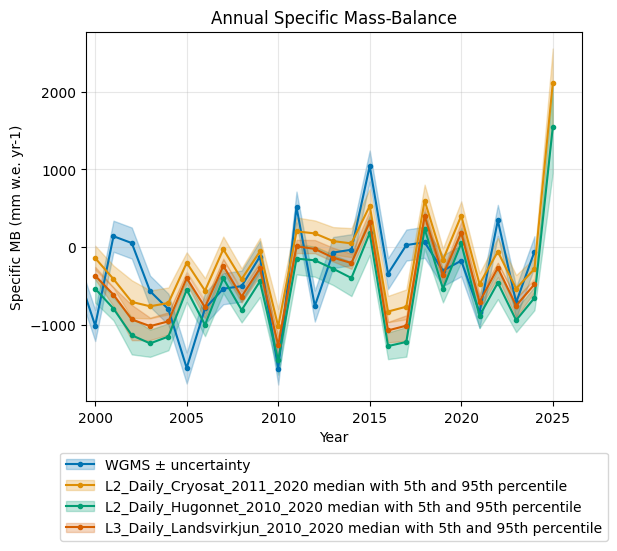

In [14]:
validator.get_validation_plot_for_layers(l2_name_list=validation_name_list, obs_name='WGMS')
plt.show()

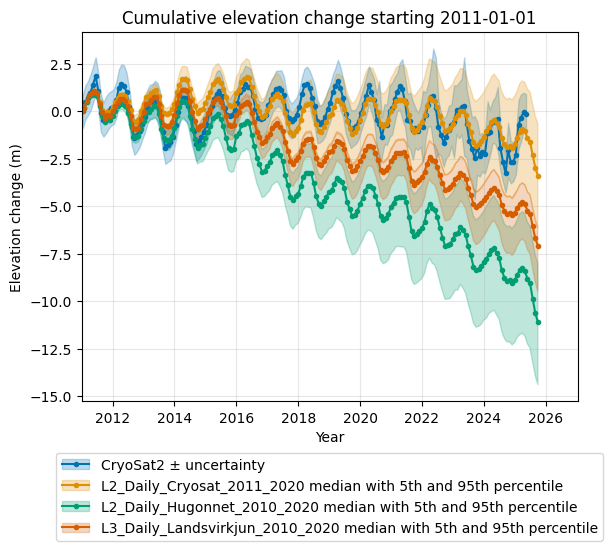

In [15]:
validator.get_validation_plot_for_layers(l2_name_list=validation_name_list, obs_name='CryoSat2')
plt.show()

## Validation with user data

Another level of **interaction** between the **user** and **DTC-Glaciers**, it is also possible to bring your **own data** and use the tools of the **validation framework** for evaluating the supported validation metrics or for creating plots for visually checking the differences.

For this wee need to provide the user data in the following format:

In [16]:
annual_mb = annual_smb.mean(dim=('y','x'))

user_observation = {
    # let the validation framework know which observation you provide
    'obs_type': 'annual_mb',
    # the actual values
    'values': annual_mb.values * 1000,
    # corresponding uncertainties
    'uncertainty': np.full(annual_mb.values.shape, 200),
    # tha observation years
    'years': np.array([yr.astype('datetime64[Y]').astype(int) + 1970 for yr in annual_mb.time_a.values]),
    # name of the data source, this will be displayed in the validation tables
    'name' : "Landsvirkjun provided annual mass balance",
}

After preparing the data you can provide it via `user_observation` and interact with the validation framwork in the same way as previously:

In [17]:
validation_data, bootstrap_args = validator.get_validation_for_layers(
    user_observation=user_observation, l2_name_list=validation_name_list, return_bootstrap_args=True)

In [18]:
validation_data['annual_mb']

,MeanAbsD (mm w.e. yr-1),MeanD (mm w.e. yr-1),MedianD (mm w.e. yr-1),RMSD (mm w.e. yr-1),CORRCOEF
Landsvirkjun provided annual mass balance 2000-2024,,,,,
L2_Daily_Cryosat_2011_2020,"501.8 (437.3, 589.3)","316.0 (183.8, 491.4)","279.4 (147.2, 505.1)","620.5 (528.9, 729.2)","0.49 (0.26, 0.71)"
L2_Daily_Hugonnet_2010_2020,"444.0 (336.7, 550.8)","-80.9 (-224.5, 93.9)","-111.2 (-282.9, 100.2)","555.5 (436.1, 668.6)","0.47 (0.23, 0.70)"
L3_Daily_Landsvirkjun_2010_2020,"439.4 (362.8, 518.7)","96.7 (-55.0, 258.2)","55.8 (-89.3, 266.8)","546.7 (452.8, 650.7)","0.48 (0.25, 0.71)"


We see in this case our newly generated **L3** data cube performes sligthly better compared to the other two options. This is axpected as parts of the data where also used for calibration and theirfore the validation is not independent.

You also can provide the `user_observation` to the plotting function and visually compare different data cubes to the provided observation:

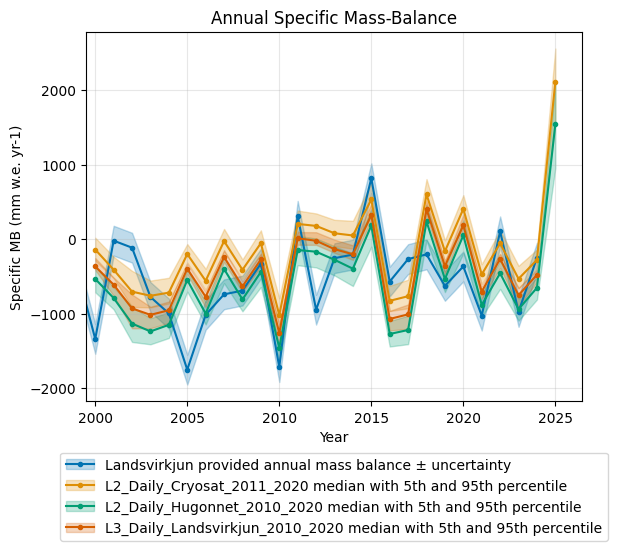

In [19]:
validator.get_validation_plot_for_layers(user_observation=user_observation, l2_name_list=validation_name_list)
plt.show()